In [1]:
import pandas_market_calendars as mcal
import pandas as pd
import numpy as np

## Remove non trading days

In [2]:
six = mcal.get_calendar('SIX')


In [3]:
df = pd.read_excel('data.xlsx')

str(df['DATE'].min().date())

'2022-01-03'

In [4]:
start = df['DATE'].min().date()
end = df['DATE'].max().date()
schedule = six.schedule(start_date=start, end_date=end)


In [5]:
df[~df['DATE'].isin(schedule.index)]

,DATE,CREDIT SUISSE GROUP - TOT RETURN IND
74,2022-04-15,333.85
75,2022-04-18,333.85
103,2022-05-26,318.95
110,2022-06-06,311.77
150,2022-08-01,261.77
255,2022-12-26,142.07
259,2022-12-30,137.98
260,2023-01-02,137.98


In [6]:
upd_df = df[df['DATE'].isin(schedule.index)]

In [7]:
def print_days_without_price_change(df):
    prev_row = None
    j = 0

    for i, row in df.iterrows():
        if j !=  0:
            if row['CREDIT SUISSE GROUP - TOT RETURN IND'] == prev_row['CREDIT SUISSE GROUP - TOT RETURN IND']:
                print(row['DATE'])

        j = 1
        prev_row = row

In [8]:
print_days_without_price_change(upd_df)

In [9]:
upd_df

,DATE,CREDIT SUISSE GROUP - TOT RETURN IND
0,2022-01-03,422.59
1,2022-01-04,427.71
2,2022-01-05,430.04
3,2022-01-06,431.43
4,2022-01-07,431.80
...,...,...
312,2023-03-15,84.71
313,2023-03-16,100.94
314,2023-03-17,92.85
315,2023-03-20,41.09


In [10]:
TOTAL = 1

In [11]:
def count_cumulitive_likelihood(likelihood):
    cum_lklhd = [likelihood[0]]
    for i in range(1, len(likelihood)):
        cum_lklhd.append(cum_lklhd[i-1] + likelihood[i])
        
    return cum_lklhd


def get_ranked_pnl(likelihood, pnl):
    ranked_pnl = pd.DataFrame({
    'PnL': pnl,
    'Weight' : likelihood
    })
    ranked_pnl = ranked_pnl.sort_values(by=['PnL'])
    ranked_pnl['Cumulative_likelihood'] = count_cumulitive_likelihood(ranked_pnl['Weight'].array)
    return ranked_pnl


def calculate_abs_var(ranked_pnl, c=0.01):
    for _, row in ranked_pnl.iterrows():
        if c < row['Cumulative_likelihood']:
            return -row['PnL']
    
    
def calculate_relative_var(ranked_pnl, c=.01):
    abs_VaR = calculate_abs_var(ranked_pnl)
    return_VaR = -abs_VaR / TOTAL
    return_expected = ranked_pnl['PnL'].mean() / TOTAL
    return TOTAL * (return_expected - return_VaR)

## Use dates before 2023

In [ ]:
prices2022= upd_df[upd_df['DATE'] < '2023-01-01'].drop('DATE', axis=1)

In [ ]:
prices2022.columns = ['CS']

In [ ]:
prices2022

In [ ]:
daily_returns2022 = prices2022.pct_change(1).tail(-1)
N2022 = len(daily_returns2022)

In [ ]:
investment_values2022 = 1 + daily_returns2022
investment_values2022.columns = ['Portfolio']


In [ ]:
investment_values2022

In [ ]:
pnl2022 = investment_values2022['Portfolio'] - TOTAL

In [ ]:
from matplotlib import pyplot as plt


plt.rcParams["figure.figsize"] = (20,10)


plt.plot(pnl2022.index.to_numpy(), pnl2022)
plt.plot([213 for _ in range(0, N2022)], np.linspace(-.2, .2, N2022))
plt.ylabel('P&L', fontsize=20)
plt.title('P&L over time', fontsize=20)
plt.show()

### Normal

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# generate some sample data
np.random.seed(123)

# calculate mean and standard deviation of the data
mu, sigma = daily_returns2022.mean()[0], daily_returns2022.std()[0]

# generate normal distribution with same mean and standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf = norm.pdf(x, mu, sigma)

# plot histogram of data and normal distribution
fig, ax = plt.subplots()
ax.hist(daily_returns2022['CS'], bins=30, density=True)
ax.plot(x, pdf, color='red', linewidth=2)
ax.set_xlabel('Daily Returns')
ax.set_ylabel('Frequency')
ax.legend(['Normal Distribution', 'Data'])
ax.set_title('Distribution of Daily Returns for CS in 2022')

plt.show()


-TOTAL * (sigma * norm.ppf(0.05) + mu)

### Equal weights 2022

In [ ]:
likelihood2022 = [1/N2022 for _ in  range(N2022)]
default_pnl2022 = get_ranked_pnl(likelihood2022, pnl2022)
calculate_abs_var(default_pnl2022), calculate_relative_var(default_pnl2022)

In [ ]:
default_pnl2022.round(3) ### extrapolation can be used

### Exponential declining weights (2022)

In [ ]:
def get_exponential_weight(alpha, i, n):
    return alpha**(n - i) * (1 - alpha) / (1 - alpha**n)

def get_exponential_weights(alpha, n):
    return np.array(
        [get_exponential_weight(alpha, i, n) for i in range(1, n+1)]
    )

alpha = .95
likelihood = get_exponential_weights(alpha, N2022)
exp_ranked_pnl2022 = get_ranked_pnl(likelihood, pnl2022)

exp_ranked_pnl2022.head(10).round(3)

### Volatility adjusted returns

In [38]:
def forecast_variance(returns, initial_value, alpha, N):
    variance_forecast = [initial_value]

    for i in range(1, N+1):
        forecast = alpha * variance_forecast[i-1]  +  (1 - alpha) * returns.iloc[i-1] **2 
        variance_forecast.append(forecast)
    
    return np.array(variance_forecast)
    
def forecast_volatility(returns, initial_value, N, alpha=.95):
    return forecast_variance(returns, initial_value, alpha, N) ** .5

In [ ]:
alpha = .95

initial_variance = 0.00064


In [ ]:
volatility_forecast2022 = forecast_volatility(daily_returns2022['CS'], initial_variance, N2022, alpha)
latest_volatility_forecast2022 = volatility_forecast2022[-1]

In [ ]:
adj_coeff_2022 = latest_volatility_forecast2022 / volatility_forecast2022[:N2022]
vol_adj_return2022 = daily_returns2022['CS'].to_numpy() * adj_coeff_2022
volatility_adjusted_portfolio2022 = TOTAL * (1 + vol_adj_return2022)
#vol_adjusted_pnl = vol_adjusted_portfolio - TOTAL

In [ ]:
#vol_adj_investment_values2022 = 1 + daily_returns2022
vol_adjusted_pnl2022 = volatility_adjusted_portfolio2022 - TOTAL#pd.DataFrame({'Portfolio': volatility_adjusted_portfolio}) - TOTAL
likelihood = [1/N2022 for _ in  range(N2022)]
ranked_vol_adjusted_pnl2022 = get_ranked_pnl(likelihood, pnl=vol_adjusted_pnl2022)
calculate_abs_var(ranked_vol_adjusted_pnl2022)

In [ ]:
ranked_vol_adjusted_pnl2022.round(3)

In [ ]:
from matplotlib import pyplot as plt


plt.rcParams["figure.figsize"] = (20,10)


plt.plot(pnl2022.index.to_numpy(), vol_adj_return2022, label='Volatility adj. daily returns')
plt.plot(pnl2022.index.to_numpy(), daily_returns2022['CS'], label='Daily returns')
plt.plot(pnl2022.index.to_numpy(), np.log(adj_coeff_2022) / 10, label='(Logarithm of adj. coefficient) / 10')

plt.axhline(0, color='black', linewidth=1)

#plt.plot([213 for _ in range(0, N2022)], np.linspace(-.2, .2, N2022))
plt.ylabel('Daily returns', fontsize=20)
plt.title('Daily returns vs volatility adj. returns (2022)', fontsize=20)
plt.legend()
plt.show()

# 2022 + 2023










































____v
____
____
____
____
____
____
____
____
________________________________________

## Use dates before 2022+2023

In [12]:
prices2023 = upd_df[upd_df['DATE'] > '2022-03-21'].drop('DATE', axis=1)

In [13]:
prices2023.columns = ['CS']

In [14]:
prices2023

,CS
56,358.97
57,353.76
58,351.34
59,351.53
60,344.08
...,...
312,84.71
313,100.94
314,92.85
315,41.09


In [25]:
daily_returns2023 = prices2023.pct_change(1).tail(-1)
N2023 = len(daily_returns2023)

In [26]:
investment_values2023 = 1 + daily_returns2023
investment_values2023.columns = ['Portfolio']


In [27]:
investment_values2023

,Portfolio
57,0.985486
58,0.993159
59,1.000541
60,0.978807
61,1.037317
...,...
312,0.757557
313,1.191595
314,0.919853
315,0.442542


In [28]:
pnl2023 = investment_values2023['Portfolio'] - TOTAL

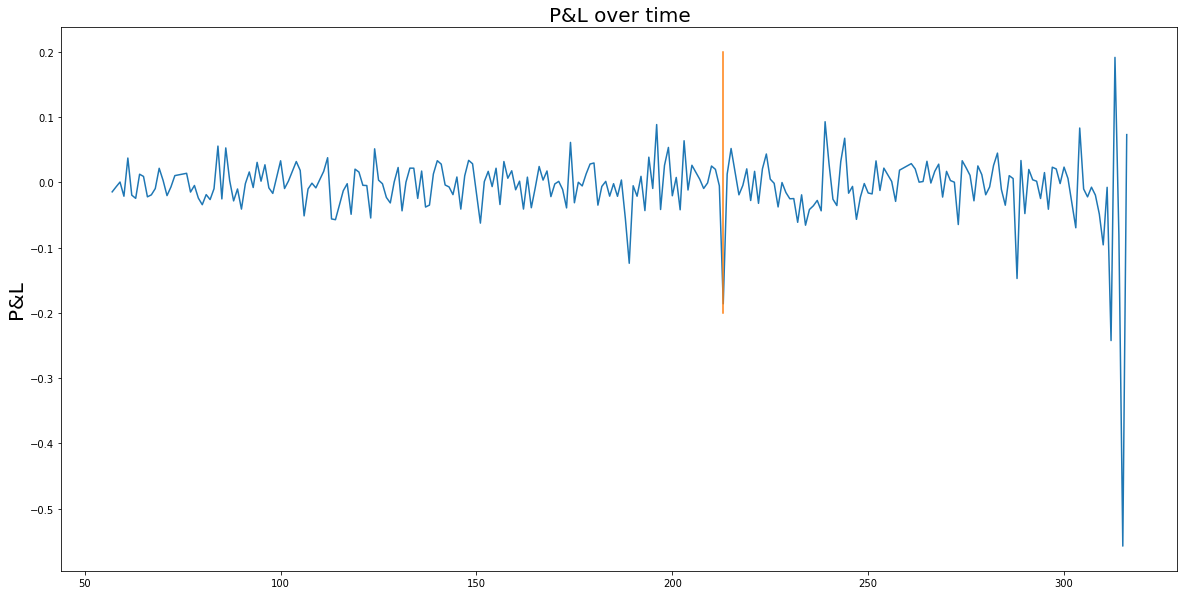

In [30]:
from matplotlib import pyplot as plt


plt.rcParams["figure.figsize"] = (20,10)


plt.plot(pnl2023.index.to_numpy(), pnl2023)
plt.plot([213 for _ in range(0, N2023)], np.linspace(-.2, .2, N2023))
plt.ylabel('P&L', fontsize=20)
plt.title('P&L over time', fontsize=20)
plt.show()

### Normal

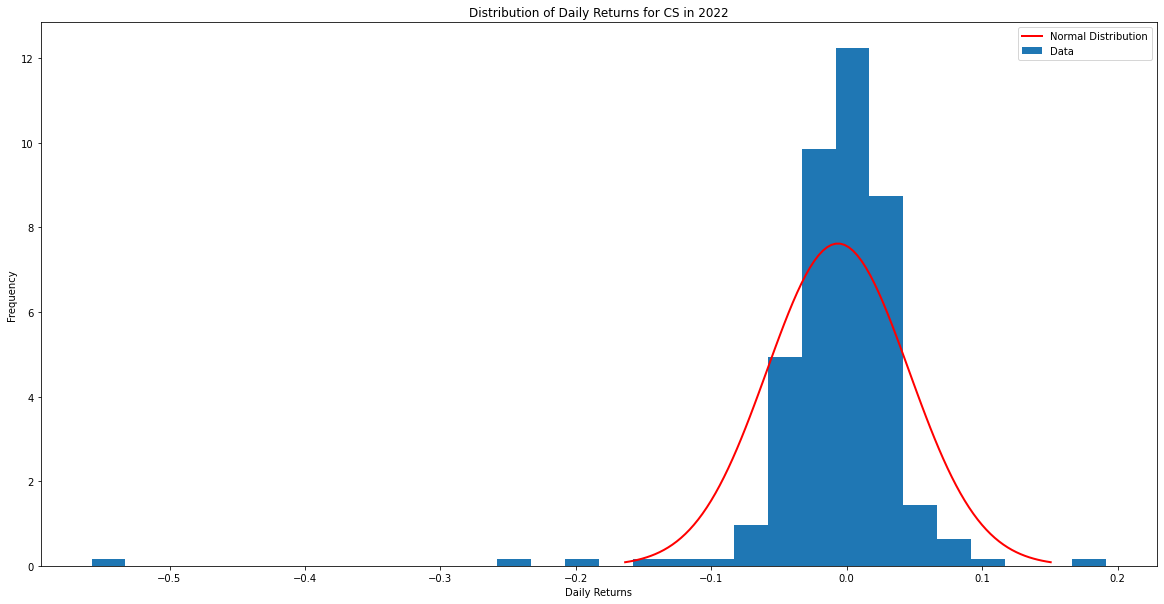

0.09262456672445364

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# generate some sample data
np.random.seed(123)

# calculate mean and standard deviation of the data
mu, sigma = daily_returns2023.mean()[0], daily_returns2023.std()[0]

# generate normal distribution with same mean and standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf = norm.pdf(x, mu, sigma)

# plot histogram of data and normal distribution
fig, ax = plt.subplots()
ax.hist(daily_returns2023['CS'], bins=30, density=True)
ax.plot(x, pdf, color='red', linewidth=2)
ax.set_xlabel('Daily Returns')
ax.set_ylabel('Frequency')
ax.legend(['Normal Distribution', 'Data'])
ax.set_title('Distribution of Daily Returns for CS in 2022')

plt.show()


-TOTAL * (sigma * norm.ppf(0.05) + mu)

### Equal weights 2023

In [33]:
likelihood2023 = [1/N2023 for _ in  range(N2023)]
default_pnl2023 = get_ranked_pnl(likelihood2023, pnl2023)
calculate_abs_var(default_pnl2023), calculate_relative_var(default_pnl2023)

(0.18603927841464496, 0.17954572510265765)

In [35]:
default_pnl2023.round(3) ### extrapolation can be used

,PnL,Weight,Cumulative_likelihood
315,-0.557,0.004,0.004
312,-0.242,0.004,0.008
213,-0.186,0.004,0.012
288,-0.147,0.004,0.016
189,-0.124,0.004,0.020
...,...,...,...
316,0.073,0.004,0.984
304,0.083,0.004,0.988
196,0.089,0.004,0.992
239,0.093,0.004,0.996


### Exponential declining weights (2022 + 2023)

In [36]:
def get_exponential_weight(alpha, i, n):
    return alpha**(n - i) * (1 - alpha) / (1 - alpha**n)

def get_exponential_weights(alpha, n):
    return np.array(
        [get_exponential_weight(alpha, i, n) for i in range(1, n+1)]
    )

alpha = .95
likelihood = get_exponential_weights(alpha, N2023)
exp_ranked_pnl2023 = get_ranked_pnl(likelihood, pnl2023)

exp_ranked_pnl2023.head(10).round(3)

,PnL,Weight,Cumulative_likelihood
315,-0.557,0.048,0.048
312,-0.242,0.041,0.088
213,-0.186,0.000,0.089
288,-0.147,0.012,0.100
189,-0.124,0.000,0.100
310,-0.096,0.037,0.137
314,-0.080,0.045,0.182
303,-0.070,0.026,0.208
234,-0.066,0.001,0.209
273,-0.065,0.006,0.214


### Volatility adjusted returns

In [40]:
alpha = .95

initial_variance = 0.00064


In [41]:
volatility_forecast2023 = forecast_volatility(daily_returns2023['CS'], initial_variance, N2023, alpha)
latest_volatility_forecast2023 = volatility_forecast2023[-1]

In [44]:
adj_coeff_2023 = latest_volatility_forecast2023 / volatility_forecast2023[:N2022]
vol_adj_return2023 = daily_returns2023['CS'].to_numpy() * adj_coeff_2023
volatility_adjusted_portfolio2023 = TOTAL * (1 + vol_adj_return2023)
#vol_adjusted_pnl = vol_adjusted_portfolio - TOTAL

In [45]:
#vol_adj_investmentvalues2022 = 1 + daily_returns2022
vol_adjusted_pnl2023 = volatility_adjusted_portfolio2023 - TOTAL#pd.DataFrame({'Portfolio': volatility_adjusted_portfolio}) - TOTAL
likelihood = [1/N2023 for _ in  range(N2023)]
ranked_vol_adjusted_pnl2023 = get_ranked_pnl(likelihood, pnl=vol_adjusted_pnl2023)
calculate_abs_var(ranked_vol_adjusted_pnl2023)

0.8055769922364285

In [46]:
ranked_vol_adjusted_pnl2023.round(3)

,PnL,Weight,Cumulative_likelihood
250,-1.016,0.004,0.004
247,-0.835,0.004,0.008
151,-0.806,0.004,0.012
223,-0.763,0.004,0.016
127,-0.681,0.004,0.020
...,...,...,...
177,0.332,0.004,0.984
112,0.363,0.004,0.988
134,0.364,0.004,0.992
25,0.384,0.004,0.996


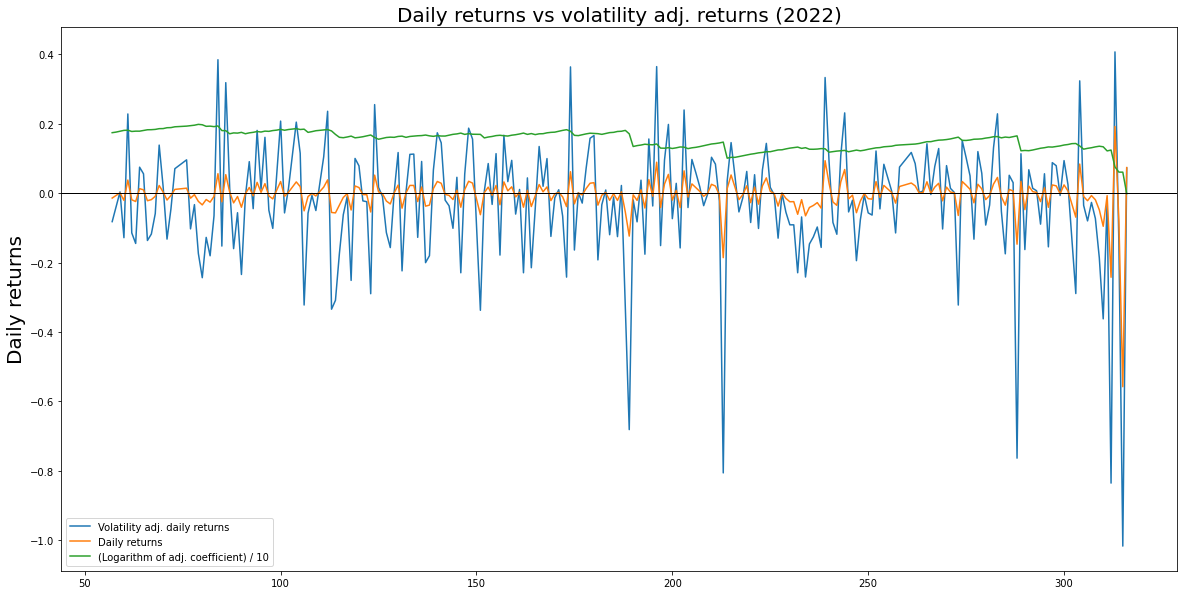

In [48]:
from matplotlib import pyplot as plt


plt.rcParams["figure.figsize"] = (20,10)


plt.plot(pnl2023.index.to_numpy(), vol_adj_return2023, label='Volatility adj. daily returns')
plt.plot(pnl2023.index.to_numpy(), daily_returns2023['CS'], label='Daily returns')
plt.plot(pnl2023.index.to_numpy(), np.log(adj_coeff_2023) / 10, label='(Logarithm of adj. coefficient) / 10')

plt.axhline(0, color='black', linewidth=1)

#plt.plot([213 for _ in range(0, N2022)], np.linspace(-.2, .2, N2022))
plt.ylabel('Daily returns', fontsize=20)
plt.title('Daily returns vs volatility adj. returns (2022)', fontsize=20)
plt.legend()
plt.show()